In [161]:
#Imprting the libararies

import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from datetime import datetime
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [162]:
#Reading the traaining data and converting datetime columns into datetime format

train1=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

In [163]:
print("Train shape: " + str(train1.shape))
print("Test shape: " + str(test.shape))
train1.tail()

Train shape: (18288, 3)
Test shape: (5112, 2)


,ID,Datetime,Count
18283,18283,25-09-2014 19:00,868
18284,18284,25-09-2014 20:00,732
18285,18285,25-09-2014 21:00,702
18286,18286,25-09-2014 22:00,580
18287,18287,25-09-2014 23:00,534


In [164]:
from math import floor
#split the train data into training set and valid set
train = train1.loc[:floor(2*len(train1)/3)]
valid = train1.loc[floor(2*len(train1)/3):]
train.set_index('Datetime', inplace = True)
valid.set_index('Datetime', inplace = True)
test.set_index('Datetime', inplace = True)

In [165]:
#parsing the datetime data 
dataparse = lambda dates: pd.datetime.strptime(dates, "%d-%m-%Y %H:%M")
train.index = train.index.map(dataparse)
valid.index = valid.index.map(dataparse)
test.index = test.index.map(dataparse)
train.head()


,ID,Count
Datetime,,
2012-08-25 00:00:00,0,8
2012-08-25 01:00:00,1,2
2012-08-25 02:00:00,2,6
2012-08-25 03:00:00,3,2
2012-08-25 04:00:00,4,2


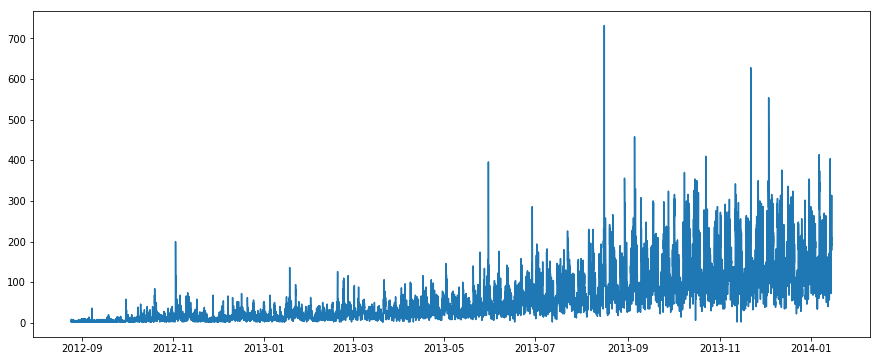

In [166]:
ts=train['Count']

plt.plot(ts)
#from this curve it is visible that our data is not sstationary

## __Stationarity checking__

Stationary: if its statistical properties such as mean, variance remain constant over time. Intuitively, if a TS has a particular behaviour over time , there is a high probability that it will follow the same in future. Criteria for stationary series:

Constant mean
Constant variable
Autocovariance that does not depend on time

In [167]:
#Creaate a Dickey fuller function to check the stationarity

from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    #determining rolling stats
    rolling_mean=pd.rolling_mean(timeseries, window=24)
    rolling_std=pd.rolling_std(timeseries, window=24)
    
    #Plot rolling statistics:
    orig=plt.plot(timeseries, color='blue', label='Original')
    mean=plt.plot(rolling_mean, color='red', label='Rolling_Mean')
    std=plt.plot(rolling_std, color='green', label='Rolling_Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest=adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    

C:\Users\manth\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=24,center=False).mean()
  
C:\Users\manth\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=24,center=False).std()
  import sys


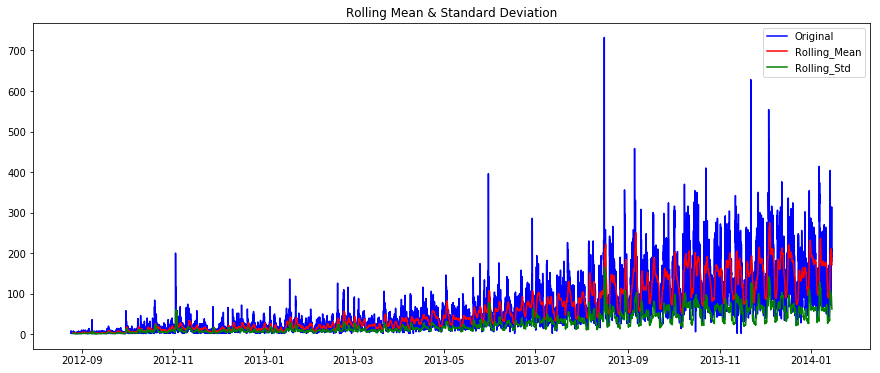

Results of Dickey-Fuller Test:
Test Statistic                -5.870107e+00
p-value                        3.255333e-07
#Lags Used                     4.000000e+01
Number of Observations Used    1.215200e+04
Critical Value (1%)           -3.430888e+00
Critical Value (5%)           -2.861778e+00
Critical Value (10%)          -2.566897e+00
dtype: float64


In [168]:
test_stationarity(ts)

The above Statistic Test show that Test statistic is less than Critical values so the data is stationary, but we still can see an increasing trend in the data. Therefore, we will try to make the data more stationary firstly. We need to remove two properties from the data: trend and seasonality.

## __Trend removing__

Trend: data varying mean over time. For example: the number of the value can increase or decrease over time. Estimating and Eliminating Trend techniques: Transformation: for example, for increasing trend, we can apply transformation which penalizes higher values more than smaller ones. For example: log, square roor,... Some ways to estimate and remove the trend:

1. Aggregation: taking average of time period lik monthly/weekly
2. Smoothing: taking rolling average
3. Polynomial fitting: fit a regression model

### __Smoothing__
Computing the rolling average of the data. Here we take the window size in 24 based on the fact that each day has 24 hours

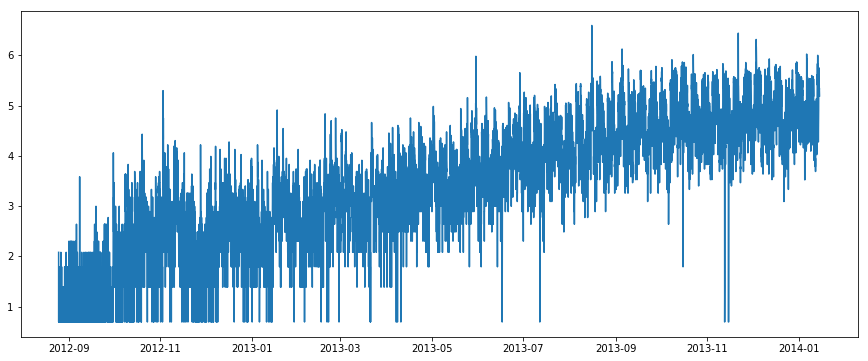

In [169]:
ts_log = np.log(ts)
plt.plot(ts_log)

C:\Users\manth\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=24,center=False).mean()
  """Entry point for launching an IPython kernel.


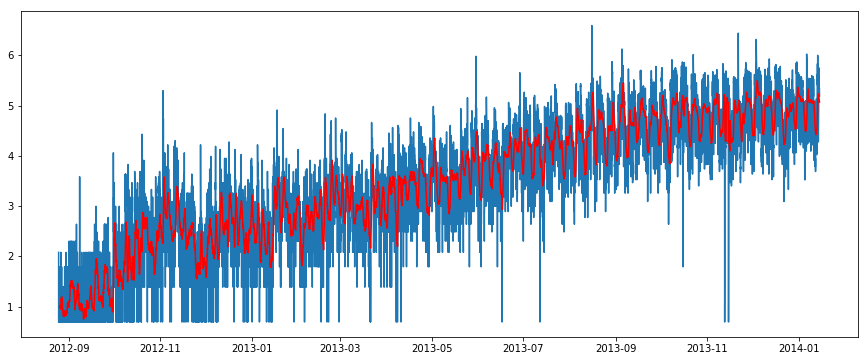

In [170]:
ts_moving_avg = pd.rolling_mean(ts_log, 24)
plt.plot(ts_log)
plt.plot(ts_moving_avg, color = 'red')

In [171]:
#removing the increasing trend 
ts_log_moving_avg_diff = ts_log - ts_moving_avg

C:\Users\manth\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=24,center=False).mean()
  
C:\Users\manth\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=24,center=False).std()
  import sys


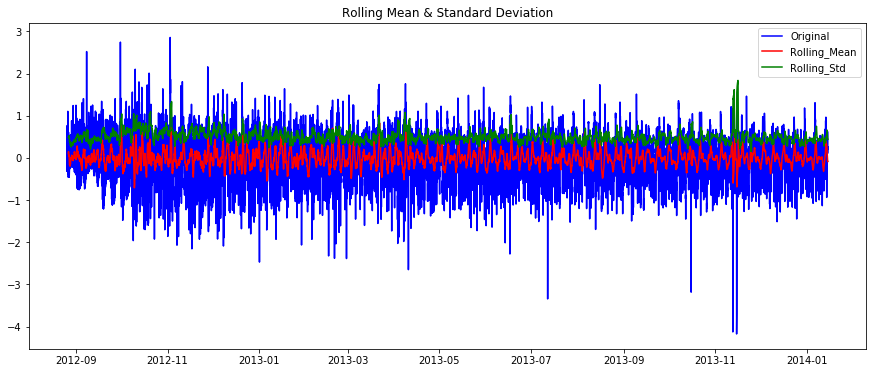

Results of Dickey-Fuller Test:
Test Statistic                   -22.510569
p-value                            0.000000
#Lags Used                        40.000000
Number of Observations Used    12129.000000
Critical Value (1%)               -3.430889
Critical Value (5%)               -2.861778
Critical Value (10%)              -2.566897
dtype: float64


In [172]:
# Since we are taking the average of 24 values, rolling mean is not defined for the first 23 values. (NaN)
ts_log_moving_avg_diff.dropna(inplace = True)
test_stationarity(ts_log_moving_avg_diff)

### __Exponentially weighted moving average__

EWMA is another popular technique where weights are assigned to all the previous values with a decay factor. Find details in here http://pandas.pydata.org/pandas-docs/stable/computation.html#exponentially-weighted-moment-functions

C:\Users\manth\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(halflife=24,min_periods=0,adjust=True,ignore_na=False).mean()
  This is separate from the ipykernel package so we can avoid doing imports until


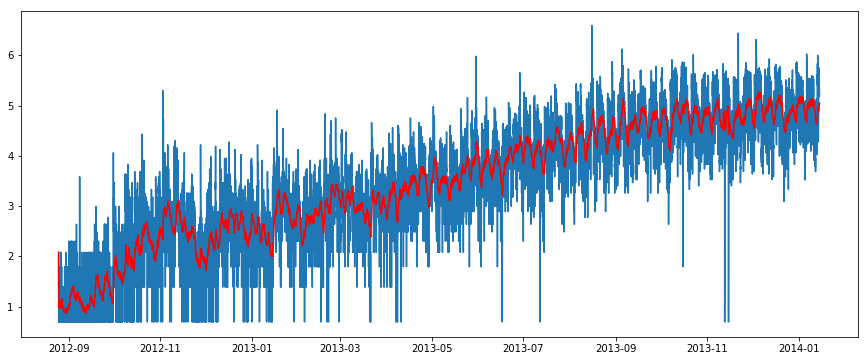

In [173]:
#applying exponential weighted moving average

expwighted_avg = pd.ewma(ts_log, halflife=24)
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')

C:\Users\manth\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=24,center=False).mean()
  
C:\Users\manth\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=24,center=False).std()
  import sys


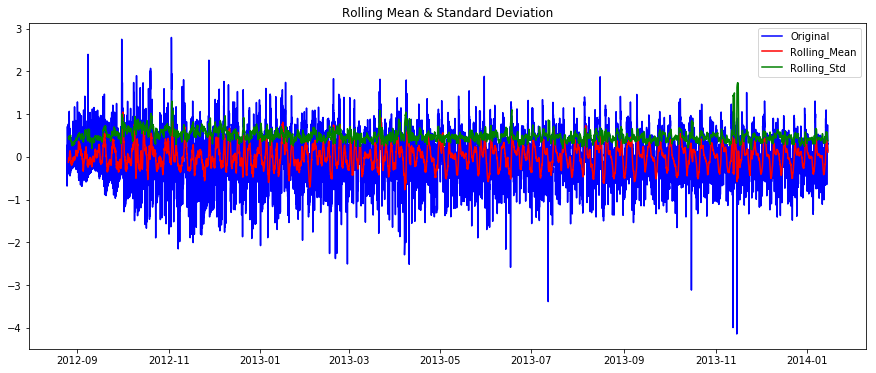

Results of Dickey-Fuller Test:
Test Statistic                   -20.177390
p-value                            0.000000
#Lags Used                        40.000000
Number of Observations Used    12152.000000
Critical Value (1%)               -3.430888
Critical Value (5%)               -2.861778
Critical Value (10%)              -2.566897
dtype: float64


In [174]:
ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff)

We got almost similar result here. The trend is almost removed.

## __Seasonality remove__
Seasonality: variations at specific time-frames. E.g: people have tendency to buy jacket in winters To remove the seasonality, we have two techniques:

Differencing: taking the difference with a particular time lag
Decomposition: modeling both trend and seasonality and removing them from the model

### __Differencing__
Usually, non-stationary series can be corrected by just differencing.The idea behind differencing is that, if the original data series does not have constant properties over time, then the change from one period to another might.

C:\Users\manth\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=24,center=False).mean()
  
C:\Users\manth\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=24,center=False).std()
  import sys


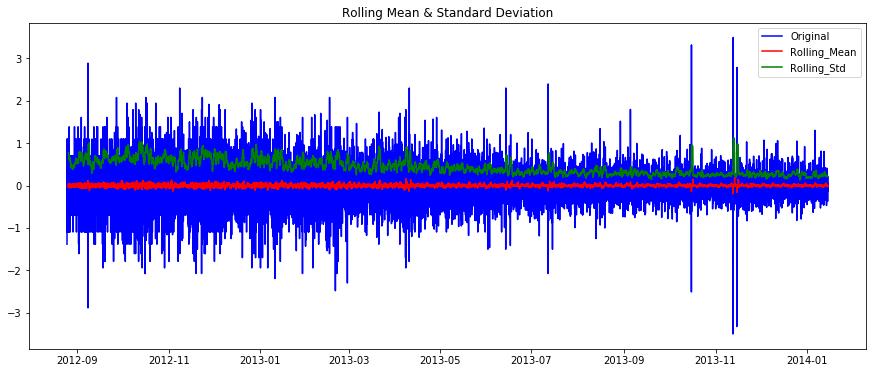

Results of Dickey-Fuller Test:
Test Statistic                   -21.889631
p-value                            0.000000
#Lags Used                        40.000000
Number of Observations Used    12151.000000
Critical Value (1%)               -3.430888
Critical Value (5%)               -2.861778
Critical Value (10%)              -2.566897
dtype: float64


In [175]:
ts_log_diff = ts_log - ts_log.shift()
test_stationarity(ts_log_diff.dropna())

In [176]:
ts_log_diff.head()

Datetime
2012-08-25 00:00:00         NaN
2012-08-25 01:00:00   -1.386294
2012-08-25 02:00:00    1.098612
2012-08-25 03:00:00   -1.098612
2012-08-25 04:00:00    0.000000
Name: Count, dtype: float64

### __Decomposition__

In decomposition, trend and seasonality are treated separatedly. Let's recall the definitions:

Trend: The increasing or decreasing value in the series.
Seasonality: The repeating short-term cycle in the series.
Residual: The random variation in the series.

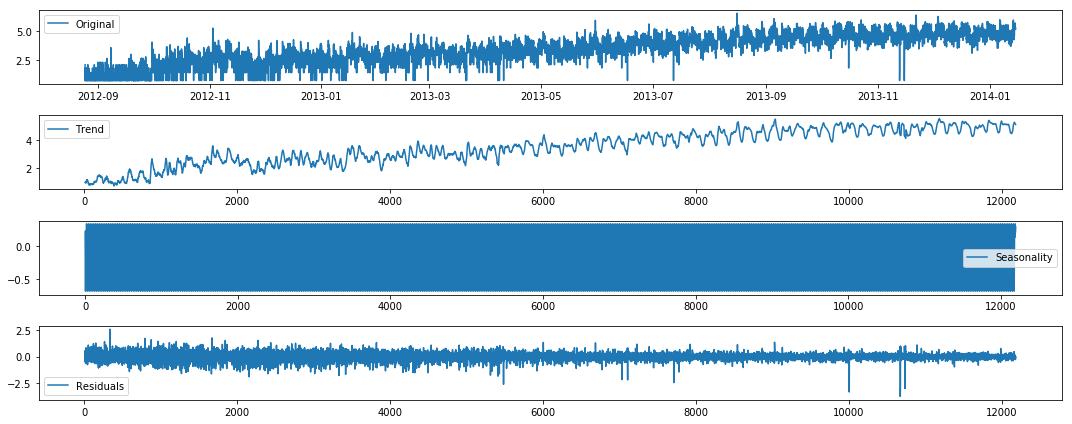

In [177]:
#Eliminating Trend and Seasonality (Decomposing)

from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(pd.DataFrame(ts_log).Count.values, freq = 24)

trend=decomposition.trend
seasonal=decomposition.seasonal
residual=decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

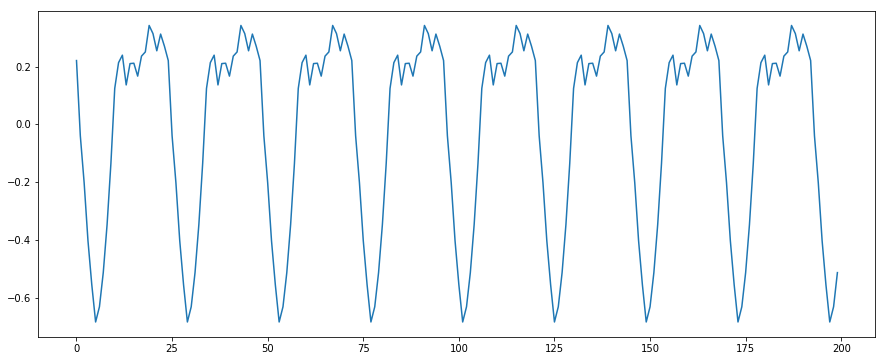

In [178]:
plt.plot(seasonal[:200], label='sub')

Here we can see that the trend, seasonality are separated out from data and we can model the residuals. The trend line show a gradual increasing trend, while the seasonality show a constant trend in counter. Lets check stationarity of residuals, which should have no pattern and normally distributed:

C:\Users\manth\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=24,center=False).mean()
  
C:\Users\manth\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=24,center=False).std()
  import sys


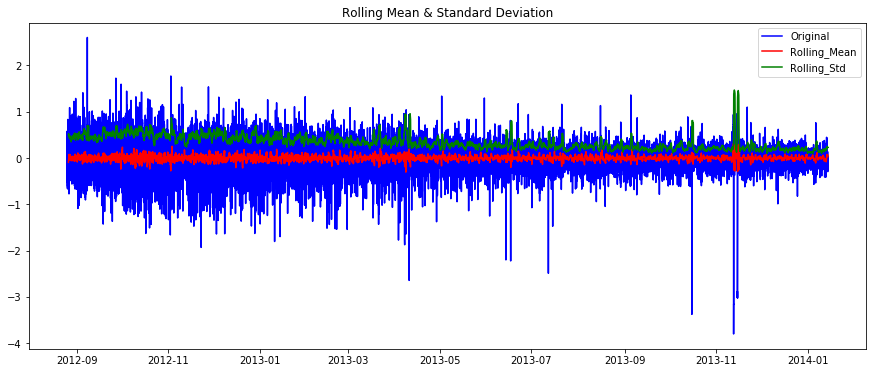

Results of Dickey-Fuller Test:
Test Statistic                   -28.600884
p-value                            0.000000
#Lags Used                        39.000000
Number of Observations Used    12129.000000
Critical Value (1%)               -3.430889
Critical Value (5%)               -2.861778
Critical Value (10%)              -2.566897
dtype: float64


In [179]:
ts_log_decompose=pd.DataFrame(residual)
ts_log_decompose['date'] = ts_log.index
ts_log_decompose.set_index('date', inplace = True)
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose[0])

## __Forecast a Time Series__
To fit and predict a time series, we use ARIMA, which stands for auto-regressive integrated moving average and is specified by these three order parameters: (p, d, q).

Auto regressive (AR(p)): referring to the use of past values in the regression equation for the series Y. p specifies the number of lags used in the model. For instance if p is 2, the predictors for x(t) will be x(t-1)x(t-2). AR(2) or, equivalently, ARIMA(2,0,0), is represented as

$$Y_t = c + \phi_1y_{t-1} + \phi_2 y_{t-2}+ e_t$$
where φ1, φ2 are parameters for the model.

Moving average (MA(q)): representing the error of the model as a combination of previous error terms et. q determines the number of terms to include in the model. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.

$$Y_t = c + \theta_1 e_{t-1} + \theta_2 e_{t-2} +...+ \theta_q e_{t-q}+ e_t$$
d represents the degree of differencing in the integrated (I(d)) component. For example, when d = 1 and d = 2:
$$Y_{d_t} = Y_t - Y_{t-1}$$$$Y_{d2_t} = Y_{d_t} - Y_{d_t-1} = (Y_t - Y_{t-1}) - (Y_{t-1} - Y_{t-2})$$
Differencing, autoregressive, and moving average components make up a non-seasonal ARIMA model which can be written as a linear equation:

$$ Y_t = c + \phi_1y_d{_{t-1}} +...+ \phi_p y_d{_{t-p}}+\theta_1 e_{t-1} +... + \theta_q e_{t-q} + e_t$$
where yd is Y differenced d times and c is a constant.

Note that the model above assumes non-seasonal series, which means you might need to de-seasonalize the series before modeling. ARIMA methodology does have its limitations. These models directly rely on past values, and therefore work best on long and stable series. Also note that ARIMA simply approximates historical patterns and therefore does not aim to explain the structure of the underlying data mechanism.

An importance concern here is how to determine the value of ‘p’ and ‘q’. We use two plots to determine these numbers. Lets discuss them first.

Autocorrelation Function (ACF): It is a measure of the correlation between the the TS with a lagged version of itself. For instance at lag 5, ACF would compare series at time instant ‘t1’…’t2’ with series at instant ‘t1-5’…’t2-5’ (t1-5 and t2 being end points).

Partial Autocorrelation Function (PACF): This measures the correlation between the TS with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons. Eg at lag 5, it will check the correlation but remove the effects already explained by lags 1 to 4.

https://people.duke.edu/~rnau/411arim3.htm

Text(0.5,1,'Autocorrelation Function')

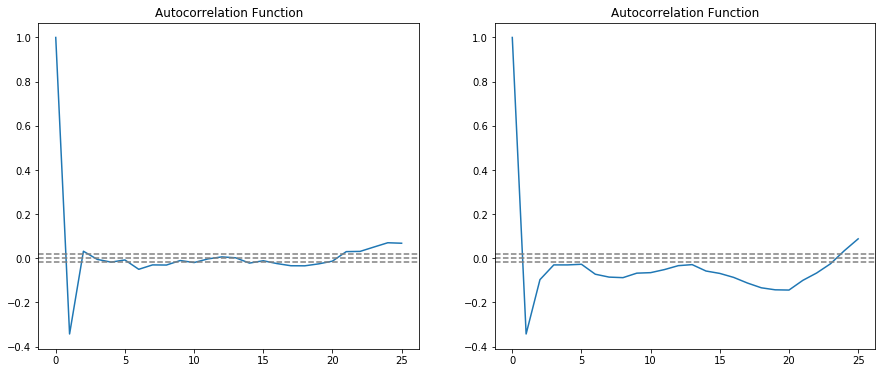

In [180]:
#ACF & PACF function
from statsmodels.tsa.stattools import acf, pacf
lag_acf=acf(ts_log_diff.dropna(), nlags=25)
lag_pacf=pacf(ts_log_diff.dropna(), nlags=25, method='ols')

#plot ACF
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff.dropna())), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff.dropna())), linestyle='--', color='gray')
plt.title('Autocorrelation Function')

#plot ACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff.dropna())), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff.dropna())), linestyle='--', color='gray')
plt.title('Autocorrelation Function')


In [181]:
ts_log_diff.head()

Datetime
2012-08-25 00:00:00         NaN
2012-08-25 01:00:00   -1.386294
2012-08-25 02:00:00    1.098612
2012-08-25 03:00:00   -1.098612
2012-08-25 04:00:00    0.000000
Name: Count, dtype: float64


In this plot, the two dotted lines on either sides of 0 are the confidence interevals. These can be used to determine the ‘p’ and ‘q’ values as:

p – The lag value where the PACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case p=1. And we also can see there is a spike at p = 1

q – The lag value where the ACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case q=1. And we can also see there is a spike at q =1 .

In [182]:
from statsmodels.tsa.arima_model import ARIMA

The p,d,q values can be specified using the order argument of ARIMA which take a tuple (p,d,q). Let model the 3 cases: AR model, MA model and the combined model. Here, RSS stands for residual sum of squares. A small RSS indicates a tight fit of the model to the data. It is used as an optimality criterion in parameter selection and model selection.

### __AR Model__

C:\Users\manth\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Users\manth\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
C:\Users\manth\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


Text(0.5,1,'RSS: 2347.6949')

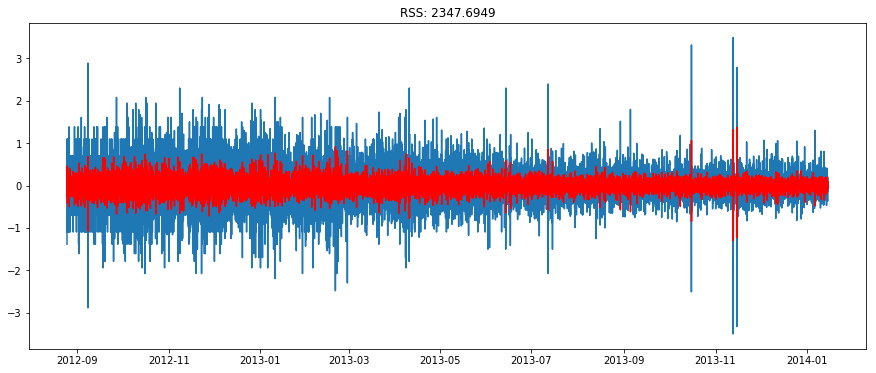

In [183]:
model = ARIMA(ts_log.dropna(), order=(0, 1, 1))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_log_diff.dropna())
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff.dropna())**2))

### __MA Model__

C:\Users\manth\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Users\manth\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
C:\Users\manth\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


Text(0.5,1,'RSS: 2373.2108')

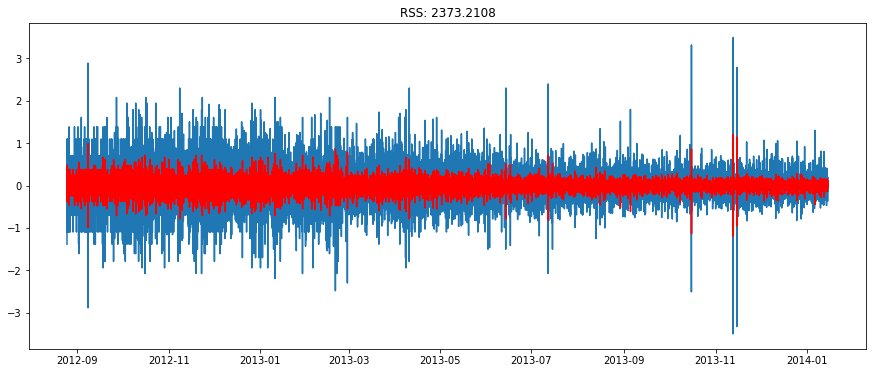

In [184]:
model = ARIMA(ts_log.dropna(), order=(1, 1, 0))  
results_MA = model.fit(disp=-1)  
plt.plot(ts_log_diff.dropna())
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff.dropna())**2))

### __Combined__

C:\Users\manth\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Users\manth\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
C:\Users\manth\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


Text(0.5,1,'RSS: 2346.9797')

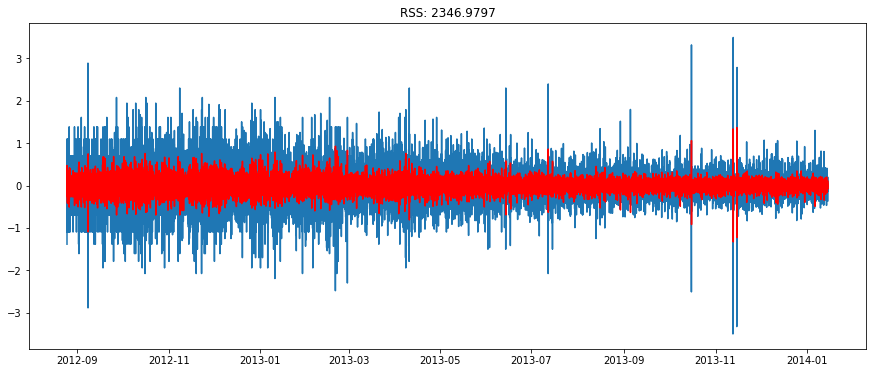

In [185]:
model = ARIMA(ts_log.dropna(), order=(1, 1, 1))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_diff.dropna())
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff.dropna())**2))


### __Taking it back to the original scale__
Lets scale it back to the original values and see how well it performs there. First step would be to store the predicted results as a separate series and observe it.

In [186]:
#bring the differencing back to the original scale
def check_prediction_diff(predict_diff, given_set):
    predict_diff= predict_diff.cumsum().shift().fillna(0)
    predict_base = pd.Series(np.log(given_set['Count'])[0], index = given_set.index)
    predict_log = predict_base.add(predict_diff, fill_value=0)
    predict = np.exp(predict_log)
    
    plt.plot(given_set['Count'], label = "Given set")
    plt.plot(predict, color = 'red', label = "Predict")
    plt.legend(loc= 'best')
    plt.title('RMSE: %.4f'% np.sqrt(sum((predict-given_set['Count'])**2)/len(given_set['Count'])))

In [187]:
def check_prediction_log(predict_log, given_set):
    predict = np.exp(predict_log)
    
    plt.plot(given_set['Count'], label = "Given set")
    plt.plot(predict, color = 'red', label = "Predict")
    plt.legend(loc= 'best')
    plt.title('RMSE: %.4f'% np.sqrt(sum((predict-given_set['Count'])**2)/len(given_set['Count'])))

In [188]:
#Tried on ARMA model 
model = ARIMA(ts_log.dropna(), order=(1, 1, 1))  
results_ARIMA = model.fit(disp=-1)  
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print (predictions_ARIMA_diff.head())

C:\Users\manth\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Users\manth\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


Datetime
2012-08-25 01:00:00    0.000293
2012-08-25 02:00:00    0.471815
2012-08-25 03:00:00   -0.262835
2012-08-25 04:00:00    0.333617
2012-08-25 05:00:00    0.108603
dtype: float64


C:\Users\manth\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


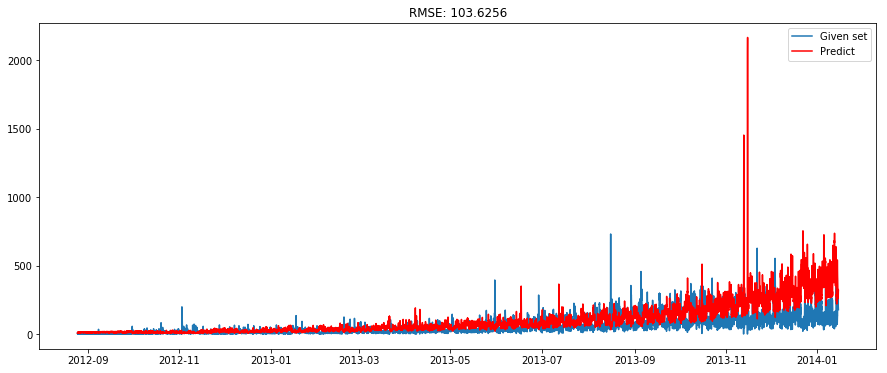

In [189]:
check_prediction_diff(predictions_ARIMA_diff, train)

__Predict on the valid set__

In [190]:
#start = train.index[0]
#end = valid.index[-1]
valid_predict_diff = results_ARIMA.predict(start = '2014-01-15 00:00:00', end ='2014-09-25 23:00:00', typ = 'levels')
print (valid_predict_diff.head())
print (valid_predict_diff.tail())

2014-01-15 00:00:00    5.318737
2014-01-15 01:00:00    5.241758
2014-01-15 02:00:00    5.239298
2014-01-15 03:00:00    5.239748
2014-01-15 04:00:00    5.240032
Freq: H, dtype: float64
2014-09-25 19:00:00    7.023797
2014-09-25 20:00:00    7.024090
2014-09-25 21:00:00    7.024383
2014-09-25 22:00:00    7.024676
2014-09-25 23:00:00    7.024969
Freq: H, dtype: float64


C:\Users\manth\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


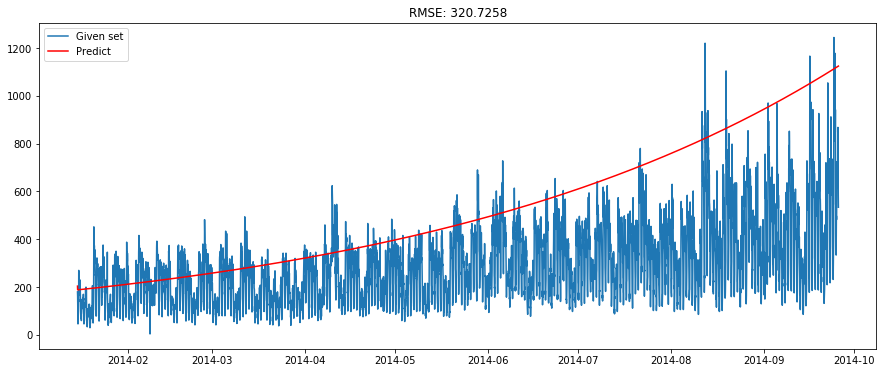

In [191]:
check_prediction_log(valid_predict_diff, valid)

We can see that RMSE iss high but we have taken only (2/3) of trainning data. 

### Lets train model with full data.

In [192]:
train1.set_index('Datetime', inplace = True)
train1.index = train1.index.map(dataparse)
train1.head()

,ID,Count
Datetime,,
2012-08-25 00:00:00,0,8
2012-08-25 01:00:00,1,2
2012-08-25 02:00:00,2,6
2012-08-25 03:00:00,3,2
2012-08-25 04:00:00,4,2


In [193]:
ts1=train1['Count']
ts_log1 = np.log(ts1)

C:\Users\manth\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=24,center=False).mean()
  
C:\Users\manth\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=24,center=False).std()
  import sys


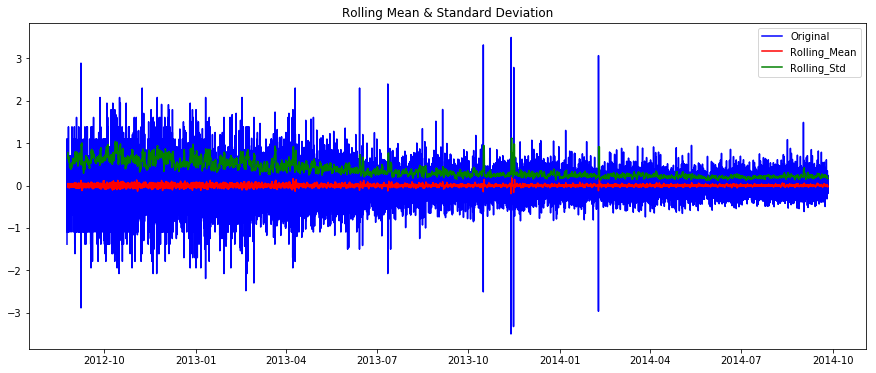

Results of Dickey-Fuller Test:
Test Statistic                   -32.041628
p-value                            0.000000
#Lags Used                        45.000000
Number of Observations Used    18241.000000
Critical Value (1%)               -3.430709
Critical Value (5%)               -2.861698
Critical Value (10%)              -2.566854
dtype: float64


In [194]:
ts_log_diff1 = ts_log1 - ts_log1.shift()
test_stationarity(ts_log_diff1.dropna())

C:\Users\manth\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Users\manth\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
C:\Users\manth\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


Text(0.5,1,'RSS: 2640.9693')

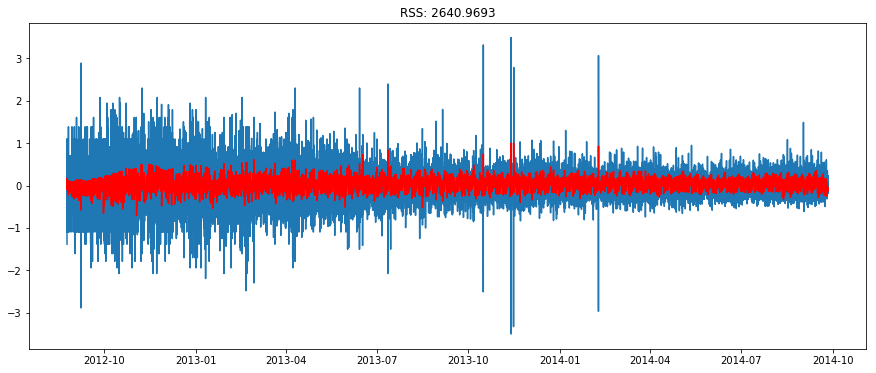

In [195]:
model = ARIMA(ts_log1.dropna(), order=(1, 1, 1))  
results_ARIMA1 = model.fit(disp=-1)  
plt.plot(ts_log_diff1.dropna())
plt.plot(results_ARIMA1.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA1.fittedvalues-ts_log_diff1.dropna())**2))

### Now predicting for Test data

In [196]:
test.tail()

,ID
Datetime,
2015-04-26 19:00:00,23395
2015-04-26 20:00:00,23396
2015-04-26 21:00:00,23397
2015-04-26 22:00:00,23398
2015-04-26 23:00:00,23399


In [197]:
test_predict_diff = results_ARIMA1.predict(start = '2014-09-26 00:00:00', end ='2015-04-26 23:00:00', typ = 'levels')
print (test_predict_diff.head())
print (test_predict_diff.tail())

2014-09-26 00:00:00    6.259788
2014-09-26 01:00:00    6.244351
2014-09-26 02:00:00    6.232805
2014-09-26 03:00:00    6.224186
2014-09-26 04:00:00    6.217771
Freq: H, dtype: float64
2015-04-26 19:00:00    7.635170
2015-04-26 20:00:00    7.635452
2015-04-26 21:00:00    7.635734
2015-04-26 22:00:00    7.636016
2015-04-26 23:00:00    7.636297
Freq: H, dtype: float64


C:\Users\manth\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


In [198]:
predict_final =pd.DataFrame(np.exp(test_predict_diff), columns=['Count']).reset_index(drop=True)

In [199]:
predict_final.head()

,Count
0,523.108058
1,515.094801
2,509.181577
3,504.812033
4,501.583784


In [200]:
test_predictions=pd.read_csv('test.csv')

In [201]:
#for i in range(len(test)):
   # test_predictions['Count'][i]=predict_final[i]
    

In [202]:
test_predictions=pd.concat([test_predictions, predict_final], axis=1)

In [203]:
test_predictions.to_csv('test_predictions.csv', index=False)